# Corrected gauge transformation on the GPU

Set parameters and environment variables

In [3]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2.5         
N = 128 
tau_sim = 1.25    
DTS = 8

# Derived parameters
a = L/N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int(tau_sim / a * DTS)
nplus = maxt//DTS     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.68        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.2 * g**2 * mu         
uv = 10.0       


nevents = 1

In [4]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
import curraun.gauge_trans as lc_gauge

We create the simulation routine

In [15]:
from tqdm import tqdm

# Simulation rutine
def simulate():
    output = {}
    
    # Derived parameters
    a = L/N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)
    
    # We create the object simulation
    s = core.Simulation(N, DT, g)

    # We initilize the Glasma fields
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)
    
    # We create the objects to store the fields at every time step
    ux_sim = np.zeros((maxt, N*N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    aeta_sim = np.zeros((maxt, N*N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We simulate the event and store the Glasma fields at every time step
    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            
            # Evolve the Glasma fields
            core.evolve_leapfrog(s)
            
            # We store the fields
            u1 = s.u1.copy()
            ux_sim[t] = u1[:, 0, :]
            
            aeta_sim[t] = s.aeta1.copy()
        
            pbar.update(1)
    
    
    # We reshape the field arrays in a suitable way for the GPu gauge transformation
    ux = ux_sim.reshape((maxt*N*N, su.GROUP_ELEMENTS))
    aeta = aeta_sim.reshape((maxt*N*N, su.GROUP_ELEMENTS))
    
    # We create the necessary objects for the gauge transformations
    nplus = maxt//DTS
    lc = lc_gauge.LCGaugeTransf(s, nplus, ux, aeta)
    
    # We create an object to store the final gauge links
    up_lc = su.GROUP_TYPE(np.zeros((nplus-1, N*N, su.GROUP_ELEMENTS)))
    
    # We copy the fields to the GPU
    lc.init()
    
    # We start the gauge transformation
    with tqdm(total=nplus) as pbar:
        for xplus in range(nplus):
                
            # We evolve the fields and perform the simulation
            lc.evolve_lc(xplus)
                
            if xplus != 0:
                up_lc[xplus-1] = lc.up_lc.copy()
                
        
            pbar.update(1)

    if use_cuda:
        cuda.current_context().deallocations.clear()
        
    
    # We write the transformed fields in a dictionary
    output["up_lc"] = up_lc
    
    return output

We perform the simulation

In [16]:
import warnings
warnings.filterwarnings('ignore')

for n in range (nevents):
    
    print('Event %i' % n)
    output = simulate()
    
    up_lc = output['up_lc']
    
    # np.save(os.path.join('simulations', 'ux_temp', 'result_%i.npy' %n), ux_out)

Event 0
Kernel xi: 0 d:  0 did not reach goal. check:  0.0017748583526983512
Kernel xi: 0 d:  1 did not reach goal. check:  0.0006828408624537959
Kernel xi: 1 d:  0 did not reach goal. check:  0.002069577985296499
Kernel xi: 1 d:  1 did not reach goal. check:  0.00027806410329591274
Kernel xi: 2 d:  0 did not reach goal. check:  0.0024872067388778106
Kernel xi: 2 d:  1 did not reach goal. check:  0.0004969443500871422
Kernel xi: 3 d:  0 did not reach goal. check:  0.0018993590206362076
Kernel xi: 3 d:  1 did not reach goal. check:  0.0019987823524734564
Kernel xi: 4 d:  0 did not reach goal. check:  0.001074849241028001
Kernel xi: 4 d:  1 did not reach goal. check:  0.005429851764558435
Kernel xi: 5 d:  0 did not reach goal. check:  0.0010483704707978548
Kernel xi: 5 d:  1 did not reach goal. check:  0.007515908340891521
Kernel xi: 6 d:  0 did not reach goal. check:  0.0015191873405508733
Kernel xi: 6 d:  1 did not reach goal. check:  0.005060038324704744
Kernel xi: 7 d:  0 did not rea

100%|██████████| 64/64 [00:00<00:00, 146.27it/s]


We plot the results

In [17]:
# We extract the color components
up_lc_r = up_lc.reshape(nplus-1, N, N, su.GROUP_ELEMENTS)
up_lc_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, up_lc_r)

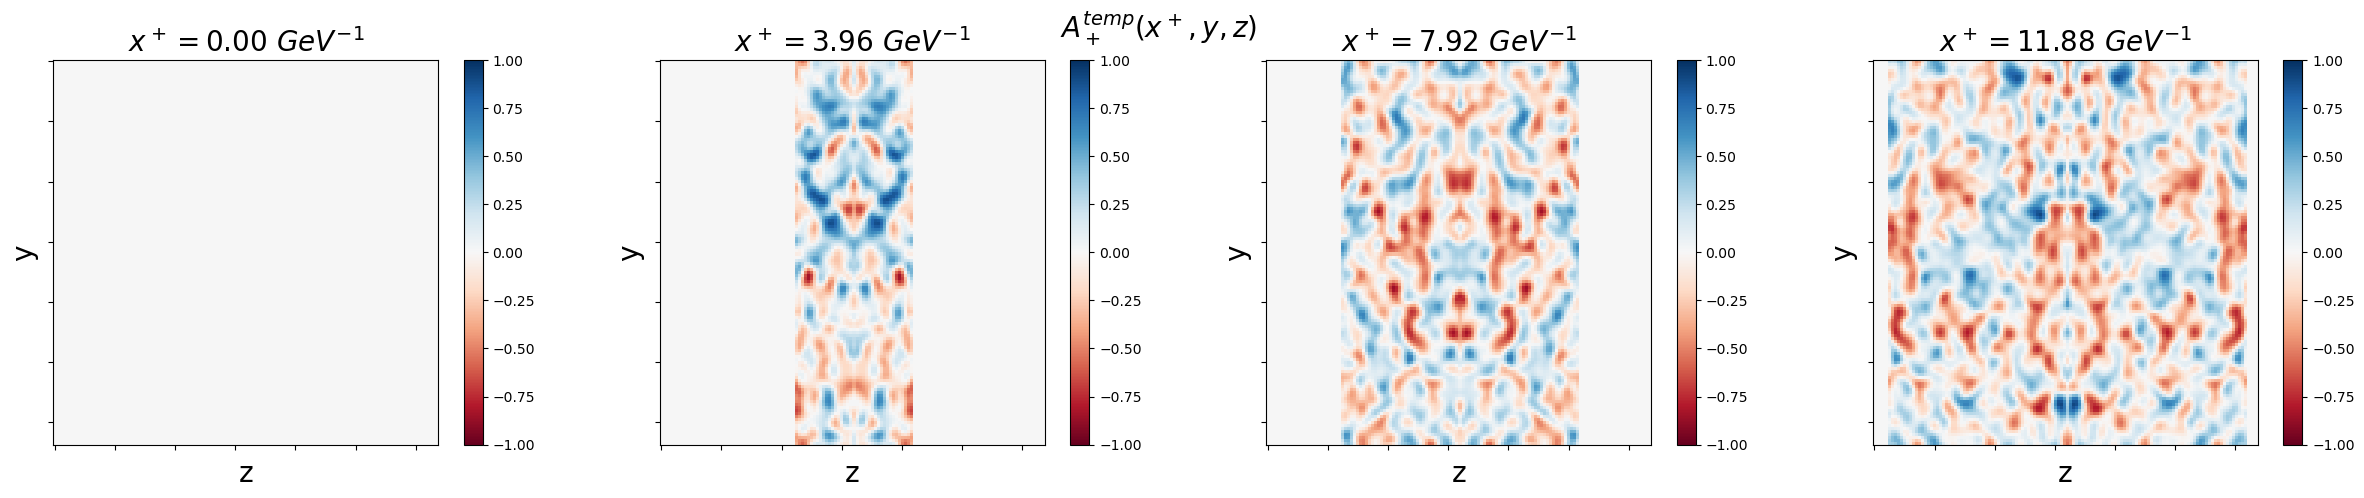

In [18]:
# We plot the temporal gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$A_+^{temp}(x^+, y, z)$', fontsize=20)

for t in range(nplus//20 + 1): 
    xplus = 20*t
    
    plot1 = axs[t].imshow(up_lc_comp[xplus, :, :, 0].real, cmap='RdBu', vmin=-1, vmax=1) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)
    axs[t].set_title(r'$x^+ = %.2f\ GeV^{-1}$' %(2*a*xplus/hbarc), fontsize=20)
    
# plt.savefig('temporal_gauge_fields')